<h2 style="background-color:#229799; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold;">
    Diabetes Prediction
</h2>

- **About the author:** Sajjad Ali Shah
- **LinkedIn:** [LinkedIn Profile](https://www.linkedin.com/in/sajjad-ali-shah47/)
- **Dataset link:** [Diabetes Dataset](https://www.kaggle.com/datasets/johndasilva/diabetes)

---

<a id="library"></a>
<div style="background-color:#229799; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold; margin:0;">
    <h2 style="color:white; font-weight:bold; margin:0;">
        <span style="font-size:25px;"></span> Import Libraries
    </h2>
</div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("./dataset/diabetes.csv")

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [5]:
df.shape

(2000, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [7]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


In [8]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

0

In [10]:
df.duplicated().sum()

1256

<div style="border: 2px solid #78B7D0; border-radius: 10px; padding: 15px;;">
    <h3>🔍 Observations:</h3>
    <ul>
        <li>📊 <strong>There are 2000 rows and 9 columns</strong> in our data.</li>
        <li>🔢 <strong>All columns are of numerical type</strong>.</li>
        <li>📈 <strong>No missing values in our data</strong>.</li>
    </ul>
</div>


<a id="exploredata"></a>
<div style="background-color:#229799; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold; margin:0;">
    <h2 style="color:white; font-weight:bold; margin:0;">
        <span style="font-size:25px;"></span> Explore Data
    </h2>
</div>


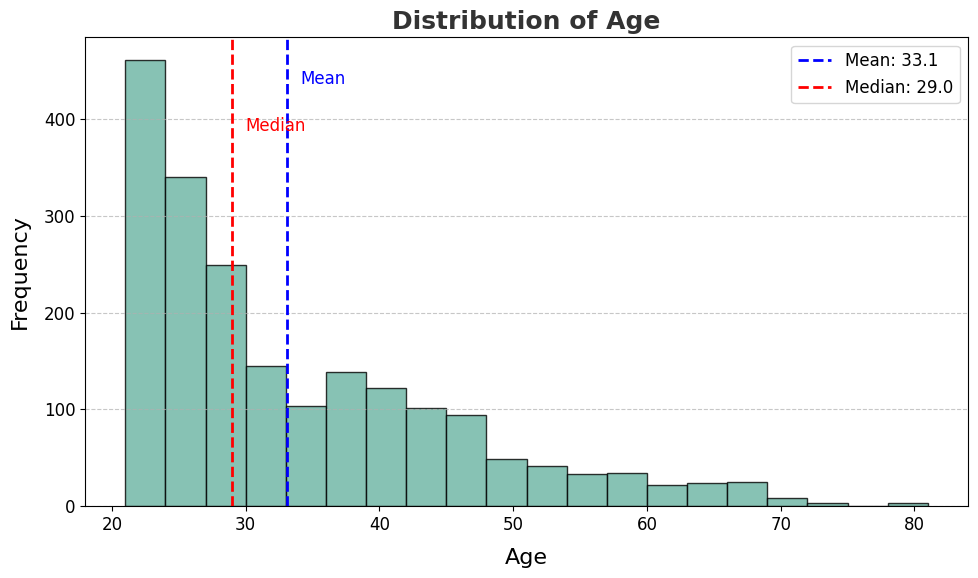

In [ ]:
mean_age = df["Age"].mean()
median_age = df["Age"].median()

# Create the histogram
plt.figure(figsize=(10, 6))  # Set a larger figure size for better visualization
plt.hist(df["Age"], bins=20, color='#69b3a2', edgecolor='black', alpha=0.8)

# Add mean and median lines
plt.axvline(mean_age, color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_age:.1f}')
plt.axvline(median_age, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_age:.1f}')

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set the title and labels
plt.title('Distribution of Age', fontsize=18, weight='bold', color='#333333')
plt.xlabel('Age', fontsize=16, labelpad=10)
plt.ylabel('Frequency', fontsize=16, labelpad=10)

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend
plt.legend(fontsize=12, frameon=True)

# Add annotations for key statistics
plt.text(mean_age + 1, plt.ylim()[1] * 0.9, 'Mean', color='blue', fontsize=12)
plt.text(median_age + 1, plt.ylim()[1] * 0.8, 'Median', color='red', fontsize=12)

# Show the plot
plt.tight_layout()  
plt.show()


<div style="border: 2px solid #78B7D0; border-radius: 10px; padding: 15px;">
  <h2>📋 Observations:</h2>
  <ul>
    <li>📊 The <strong>histogram illustrates the Age distribution</strong> in the dataset.</li>
    <li>📐 The <strong>mean age is 33.1 years</strong>, marked by the blue dashed line.</li>
    <li>📍 The <strong>median age is 29 years</strong>, indicated by the red dashed line.</li>
    <li>📈 The <strong>distribution is right-skewed</strong>, with a peak concentration between 20 and 30 years.</li>
  </ul>
</div>


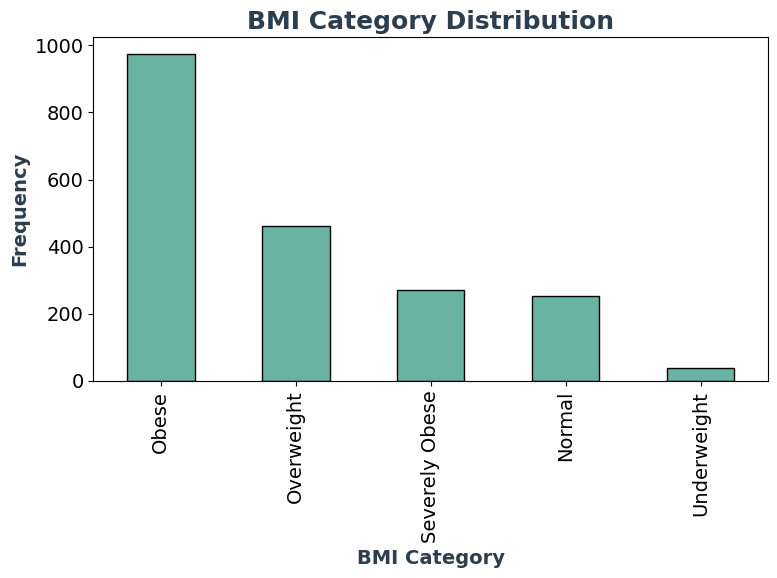

In [47]:
# Categorize BMI into different ranges
bins = [0, 18.5, 24.9, 29.9, 40, 100]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese']
df['BMI Category'] = pd.cut(df['BMI'], bins=bins, labels=labels, right=False)

# Create a bar plot of the BMI categories
category_counts = df['BMI Category'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='#69b3a2', edgecolor='black')

# Set the title and labels
plt.title('BMI Category Distribution', fontsize=18, fontweight='bold', color='#2b3e50')
plt.xlabel('BMI Category', fontsize=14, fontweight='bold', color='#2b3e50')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='#2b3e50')

# Display the plot
plt.tight_layout()
plt.show()
